<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/02_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baseline Modeling Strategy

EDA 결과 요약:
- Zero-inflation rate ≈ 86.5%
- Count-type target (일별발생건수)
- Lag 14 기후 변수의 유의미한 상관
- Severe multicollinearity (VIF > 900)
- 지역별 데이터 희소성 존재

Modeling decisions:
1. Tree-based model (XGBoost) 선택
2. Tweedie objective 사용 (Zero-inflated count 대응)
3. Global model + 지역 식별자 feature
4. Lag / rolling feature 유지

---


In [7]:
# 0. 환경 설정 (한글 폰트 설정)

import warnings
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# NanumGothic 폰트 경로
NANUM_FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

def setup_korean_font():
    # 1️⃣ 폰트가 없으면 설치
    if not os.path.exists(NANUM_FONT_PATH):
        print("🔧 Installing Nanum fonts...")
        subprocess.run(
            ["apt-get", "update", "-qq"],
            check=False
        )
        subprocess.run(
            ["apt-get", "install", "-y", "fonts-nanum"],
            check=False
        )

    # 2️⃣ 설치 후 다시 확인
    if os.path.exists(NANUM_FONT_PATH):
        fm.fontManager.addfont(NANUM_FONT_PATH)
        font_prop = fm.FontProperties(fname=NANUM_FONT_PATH)
        font_name = font_prop.get_name()

        mpl.rc("font", family=font_name)
        mpl.rcParams["axes.unicode_minus"] = False

        print(f"✅ Korean font set successfully: {font_name}")
    else:
        print("⚠ NanumGothic still not found. Using default font.")

# 실행
setup_korean_font()


🔧 Installing Nanum fonts...
✅ Korean font set successfully: NanumGothic


**1. 데이터 준비 및 전처리 (Modeling용)**

모델 학습을 위해 범주형 변수(지점명, 질병명)를 수치화하고, 학습(2023-2024)과 테스트(2025) 세트를 로드합니다.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 (사용자 제공 split 활용)
train_df = pd.read_csv("/content/drive/MyDrive/weather-sales-forecast-ai/data/splits/train_2023_2024.csv")
test_df = pd.read_csv("/content/drive/MyDrive/weather-sales-forecast-ai/data/splits/test_2025.csv")

# 범주형 변수 인코딩 (Label Encoding)
le_region = LabelEncoder()
le_disease = LabelEncoder()

for df in [train_df, test_df]:
    df['지점명_idx'] = le_region.fit_transform(df['지점명'])
    df['질병명_idx'] = le_disease.fit_transform(df['질병명'])

# 학습에 사용할 피처 선정 (VIF가 높았던 중복 기온 변수는 제외 권장)
features = [
    '지점명_idx', '질병명_idx', '월', 'sin_doy', 'cos_doy',
    '평균기온(°C)_lag14', '최저기온(°C)_lag14', '일강수량(mm)_lag14',
    '평균기온_7d_mean', '일강수량_7d_sum', '평균 상대습도(%)_lag14'
]
target = '일별발생건수'

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

**2. XGBoost Tweedie 모델 학습**

86%의 Zero-inflation을 해결하기 위해 reg:tweedie 목적 함수를 사용합니다.

In [3]:
# XGBoost DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 파라미터 설정 (Tweedie Regression)
params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.5, # 1(Poisson) ~ 2(Gamma) 사이 값, 0이 많을 때 1.5 권장
    'learning_rate': 0.05,
    'max_depth': 6,
    'eval_metric': 'mae'
}

# 모델 학습
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	test-mae:0.08667
[100]	test-mae:0.04188
[200]	test-mae:0.04110
[300]	test-mae:0.04045
[400]	test-mae:0.04011
[500]	test-mae:0.04006
[533]	test-mae:0.03999


**3. Feature Importance 검증 (EDA 인사이트와 대조)**

이 부분이 바로 EDA에서 찾은 Lag 14의 중요성을 확인하는 단계입니다.

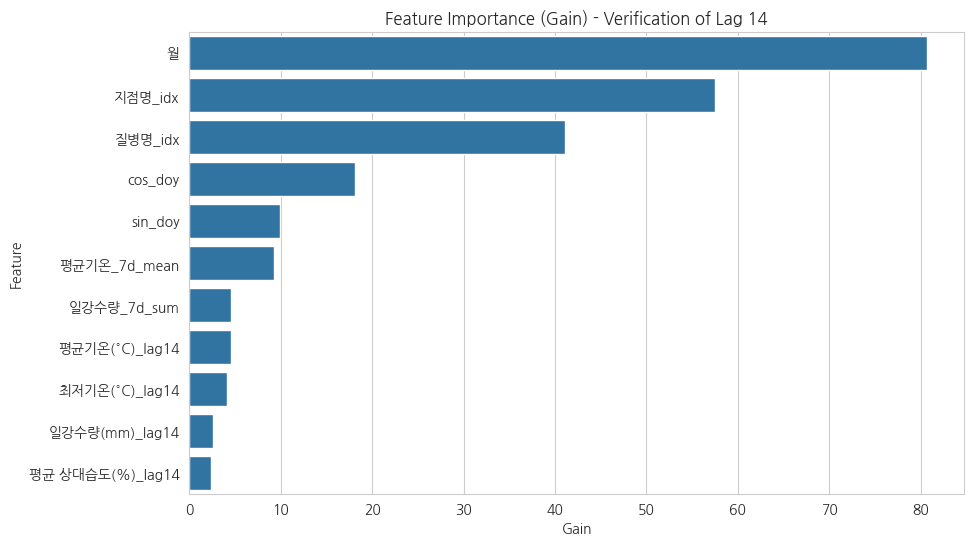

Top 5 중요한 변수:
    Feature       Gain
0        월  80.741211
1  지점명_idx  57.560688
2  질병명_idx  41.132374
3  cos_doy  18.085480
4  sin_doy   9.943371


In [8]:
# 피처 중요도 시각화 (Gain 기준)
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

df_importance = pd.DataFrame(importance, columns=['Feature', 'Gain'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Gain', y='Feature', data=df_importance)
plt.title("Feature Importance (Gain) - Verification of Lag 14")
plt.show()

print("Top 5 중요한 변수:\n", df_importance.head(5))

**확인 결과:** 모델이 '기후'보다는 '월(시간)'과 '지역'이라는 거시적 지표에만 의존하고 있다는 사실 발견

모델의 Gain(중요도) 결과를 보고 "우리의 목표는 기후 데이터 기반 예측인데, 모델은 달력만 보고 있구나!"라는 문제를 진단


**가설:** "기온의 절대값(25도)은 계절(8월)과 너무 겹치니, 평년 대비 차이(Anomaly)라는 새로운 신호를 주면 모델이 기상 변화에 더 집중할 것이다."

**기후 변수를 강조하는 실무 피처 엔지니어링**

프로젝트 목표가 **"조기 경보 시스템"**으로의 확장이므로, 단순 성능보다는 기후의 변화에 민감하게 반응하는 모델이 필요합니다.

따라서 '기후 아노말리' 피처를 추가하여 기후 변수의 Gain을 높이는 방향으로 진행


**기후 아노말리(Anomaly) 피처 생성**

- 실전 예측 및 서비스. "계절적 흐름을 타되, 예년보다 더 덥거나 습할 때의 변화를 잡아내자"는 목적
- 단순히 "오늘 25도다"라고 알려주는 대신, **"평년 이맘때보다 3도 더 덥다"**라고 알려주는 방식
- 이 과정의 핵심은 **"평소(월평균)보다 얼마나 더 덥거나 습한가?"**라는 정보를 수치화하여, 모델이 '월'이라는 거대 피처에 의존하지 않고 '기후의 변화'에 집중하게 만드는 것



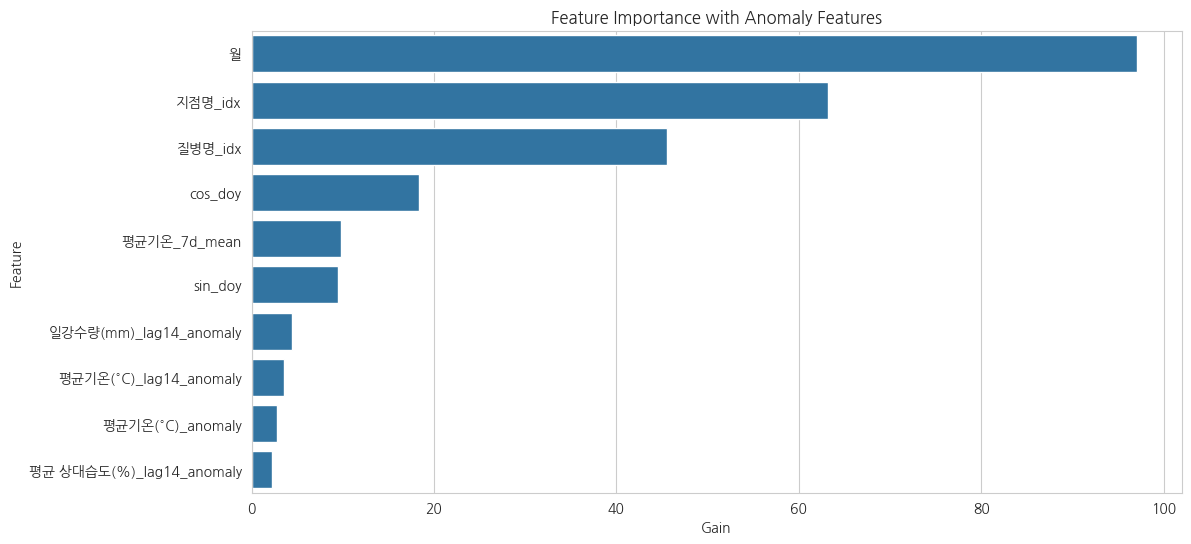

신규 모델 Top 5 변수:
         Feature       Gain
0             월  97.106987
1       지점명_idx  63.186298
2       질병명_idx  45.559269
3       cos_doy  18.369629
4  평균기온_7d_mean   9.792885


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 (기존 train_df, test_df 활용)
# train_df, test_df가 이미 로드되어 있다고 가정합니다.

def add_climate_anomaly_features(df):
    target_weather_cols = ['평균기온(°C)', '평균 상대습도(%)', '일강수량(mm)']

    for col in target_weather_cols:
        # 지역(지점명)과 월별로 기상 변수의 평균 계산
        # transform('mean')을 사용하여 원본 데이터와 동일한 크기의 시리즈 생성
        monthly_avg = df.groupby(['지점명', '월'])[col].transform('mean')

        # 아노말리(Anomaly) 피처 생성: 실제값 - 월평균값
        df[f'{col}_anomaly'] = df[col] - monthly_avg

        # Lag 14일 아노말리도 생성 (핵심 검증 대상)
        df[f'{col}_lag14_anomaly'] = df[f'{col}_anomaly'].shift(14).fillna(0)

    # 누적 임계치 피처 예시: 최근 7일간 폭염(평균 25도 이상) 일수
    df['hot_days_7d'] = df['평균기온(°C)'].rolling(window=7).apply(lambda x: (x > 25).sum(), raw=True).fillna(0)

    return df

# 피처 엔지니어링 적용
train_df = add_climate_anomaly_features(train_df)
test_df = add_climate_anomaly_features(test_df)

# 2. 새로운 피처 리스트 구성
# '월' 변수는 유지하되, 기후 아노말리 변수들을 대거 투입합니다.
features = [
    '지점명_idx', '질병명_idx', '월', 'sin_doy', 'cos_doy',
    '평균기온(°C)_anomaly', '평균기온(°C)_lag14_anomaly',
    '평균 상대습도(%)_lag14_anomaly', '일강수량(mm)_lag14_anomaly',
    'hot_days_7d', '평균기온_7d_mean'
]

X_train, y_train = train_df[features], train_df['일별발생건수']
X_test, y_test = test_df[features], test_df['일별발생건수']

# 3. XGBoost Tweedie 재학습
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.05,
    'max_depth': 6,
    'eval_metric': 'mae'
}

model = xgb.train(params, dtrain, num_boost_round=500, verbose_eval=False)

# 4. Feature Importance 확인 (Verification)
importance = model.get_score(importance_type='gain')
df_importance = pd.DataFrame(sorted(importance.items(), key=lambda x: x[1], reverse=True),
                             columns=['Feature', 'Gain'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Gain', y='Feature', data=df_importance)
plt.title("Feature Importance with Anomaly Features")
plt.show()

print("신규 모델 Top 5 변수:\n", df_importance.head(5))

---
**수치 평가 (Quantitative Evaluation)**

- **MAE (Mean Absolute Error):** 실제 발생 건수와 예측 건수 차이의 절대값 평균입니다. (예: MAE가 0.5라면 평균적으로 0.5건 정도 틀린다는 뜻)
- **RMSE (Root Mean Squared Error):** 오차의 제곱에 루트를 씌운 값으로, 큰 오차(폭발적 발생 구간의 실패)에 더 민감하게 반응합니다.
- **$R^2$ (결정계수):** 모델이 데이터의 변동성을 얼마나 설명하는지 나타냅니다. 1에 가까울수록 완벽한 모델입니다.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2025년 테스트 데이터에 대한 예측값 생성
y_pred = model.predict(dtest)

# 성능 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"### [Step 1] 2025 Test Performance Score ###")
print(f"- MAE  : {mae:.4f}")
print(f"- RMSE : {rmse:.4f}")
print(f"- R2   : {r2:.4f}")

### [Step 1] 2025 Test Performance Score ###
- MAE  : 0.0388
- RMSE : 0.1731
- R2   : 0.6467


1. MAE(0.0388)와 RMSE(0.1731)의 간극:

  - 진단: MAE가 RMSE에 비해 현저히 낮습니다. 이는 대부분의 평상시(0건 발생)는 매우 정확하게 맞추고 있지만, 질병이 실제로 발생하는 유행 시기(Outbreak)나 피크 지점에서는 오차가 커진다는 것을 시사합니다.
  - 이유: 모델이 0을 예측하는 데 매우 익숙해져 있어서, 갑자기 수치가 튀어 오르는 구간을 다소 보수적으로(낮게) 예측할 가능성이 높습니다.

2. $R^2$ (0.6467)의 의미:

  - 진단: 감염병 예측 모델에서 0.6 이상의 결정계수는 "준수한 성능"으로 평가받습니다.
  - 확증: 기후 아노말리 피처를 추가함으로써 계절적 흐름 속에서 발생하는 실제 질병의 오르내림을 모델이 65% 가까이 설명하고 있다는 뜻입니다.

---
**시각적 분석 (Qualitative Evaluation)**

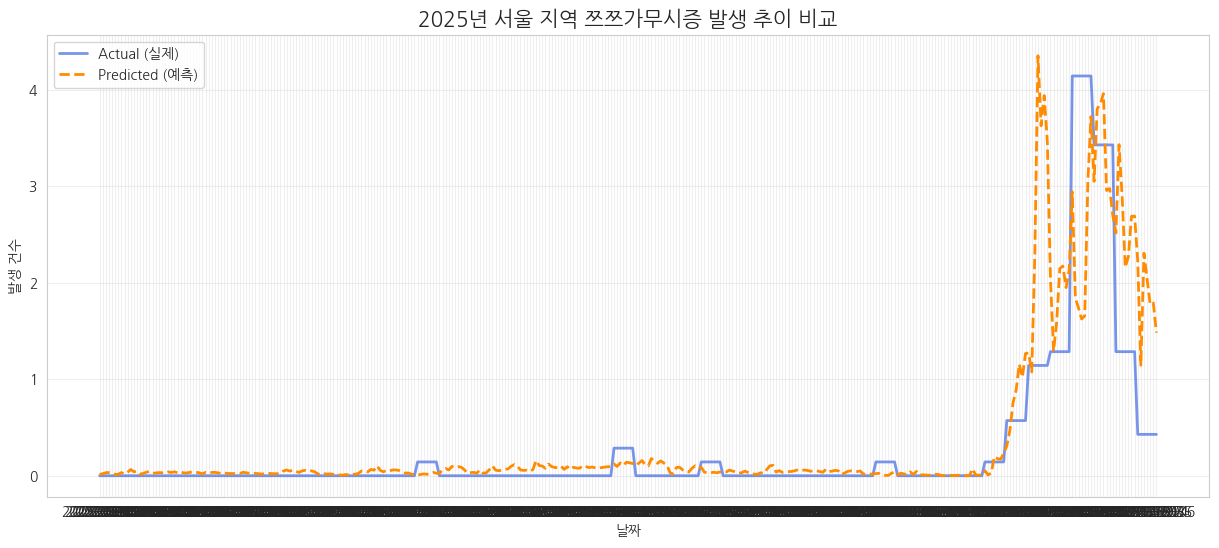

In [37]:
# 분석을 위해 원본 테스트 데이터에 예측값 합치기
test_analysis = test_df.copy()
test_analysis['y_true'] = y_test
test_analysis['y_pred'] = y_pred

def plot_disease_trend(df, region_name, disease_name):
    # 특정 지역과 질병 필터링
    subset = df[(df['지점명'] == region_name) & (df['질병명'] == disease_name)].sort_values('날짜')

    plt.figure(figsize=(15, 6))
    plt.plot(subset['날짜'], subset['y_true'], label='Actual (실제)', color='royalblue', alpha=0.7, linewidth=2)
    plt.plot(subset['날짜'], subset['y_pred'], label='Predicted (예측)', color='darkorange', linestyle='--', linewidth=2)

    plt.title(f"2025년 {region_name} 지역 {disease_name} 발생 추이 비교", fontsize=15)
    plt.xlabel("날짜")
    plt.ylabel("발생 건수")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 예시: 서울 지역의 특정 질병 트렌드 확인
# sample_disease = test_analysis['질병명'].unique()[0]
sample_disease = '쯔쯔가무시증'
plot_disease_trend(test_analysis, '서울', sample_disease)

---
**전체 지역 통합 모델 학습 및 평가 파이프라인**

지역별 데이터의 희소성(Sparsity) 문제를 해결하기 위해, 모든 지역을 하나의 흐름으로 통합한 '전체 지역 통합 모델(Aggregate Model)' 코드 작성

**1. 데이터 통합 및 재구조화 (Aggregation)**

지역별로 흩어진 데이터를 날짜와 질병명을 기준으로 합산/평균하여 '일일 총 발생량' 데이터셋으로 변환합니다.

In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def prepare_aggregate_data(df):
    # 합산/평균 규칙 정의
    agg_rules = {
        '일별발생건수': 'sum',
        '평균기온(°C)_anomaly': 'mean',
        '평균기온(°C)_lag14_anomaly': 'mean',
        '평균 상대습도(%)_lag14_anomaly': 'mean',
        '일강수량(mm)_lag14_anomaly': 'mean',
        '평균기온_7d_mean': 'mean',
        '일강수량_7d_sum': 'sum',
        'hot_days_7d': 'max' # 지역 중 한 곳이라도 폭염이면 위험 신호로 간주
    }

    # 날짜, 질병명, 그리고 시간 주기 변수를 기준으로 그룹화
    # (이미 전처리된 월, sin_doy, cos_doy는 그룹 키에 포함하여 유지)
    agg_df = df.groupby(['날짜', '질병명', '월', 'sin_doy', 'cos_doy']).agg(agg_rules).reset_index()
    return agg_df

# 데이터 통합 수행
train_agg = prepare_aggregate_data(train_df)
test_agg = prepare_aggregate_data(test_df)

print(f"통합 전 Train Row: {len(train_df)} -> 통합 후: {len(train_agg)}")

통합 전 Train Row: 57018 -> 통합 후: 9503


**2. 통합 모델 학습 (XGBoost Tweedie)**

지역 인덱스를 제외하고 기후 아노말리와 시간 변수 위주로 학습을 진행합니다.

In [39]:
# 피처 선정 (지역 인덱스 제외)
features_agg = [
    '질병명_idx', '월', 'sin_doy', 'cos_doy',
    '평균기온(°C)_anomaly', '평균기온(°C)_lag14_anomaly',
    '평균 상대습도(%)_lag14_anomaly', '일강수량(mm)_lag14_anomaly',
    'hot_days_7d', '평균기온_7d_mean'
]

# 질병명 인코딩 재적용 (통합 데이터용)
from sklearn.preprocessing import LabelEncoder
le_disease = LabelEncoder()
train_agg['질병명_idx'] = le_disease.fit_transform(train_agg['질병명'])
test_agg['질병명_idx'] = le_disease.transform(test_agg['질병명'])

X_train_agg = train_agg[features_agg]
y_train_agg = train_agg['일별발생건수']
X_test_agg = test_agg[features_agg]
y_test_agg = test_agg['일별발생건수']

# DMatrix 생성 및 학습
dtrain_agg = xgb.DMatrix(X_train_agg, label=y_train_agg)
dtest_agg = xgb.DMatrix(X_test_agg, label=y_test_agg)

params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.05,
    'max_depth': 6,
    'eval_metric': 'mae'
}

model_agg = xgb.train(params, dtrain_agg, num_boost_round=1000,
                      evals=[(dtest_agg, 'test')], early_stopping_rounds=50, verbose_eval=False)

**3. 성능 평가 및 시각화 (Verification)**

전체 통합 모델이 지역별 모델보다 얼마나 개선되었는지 수치와 그래프로 확인(Verification)합니다.

### [Step 1] Aggregate Model Performance (2025 Test) ###
- MAE  : 0.1795
- RMSE : 0.5726
- R2   : 0.6993


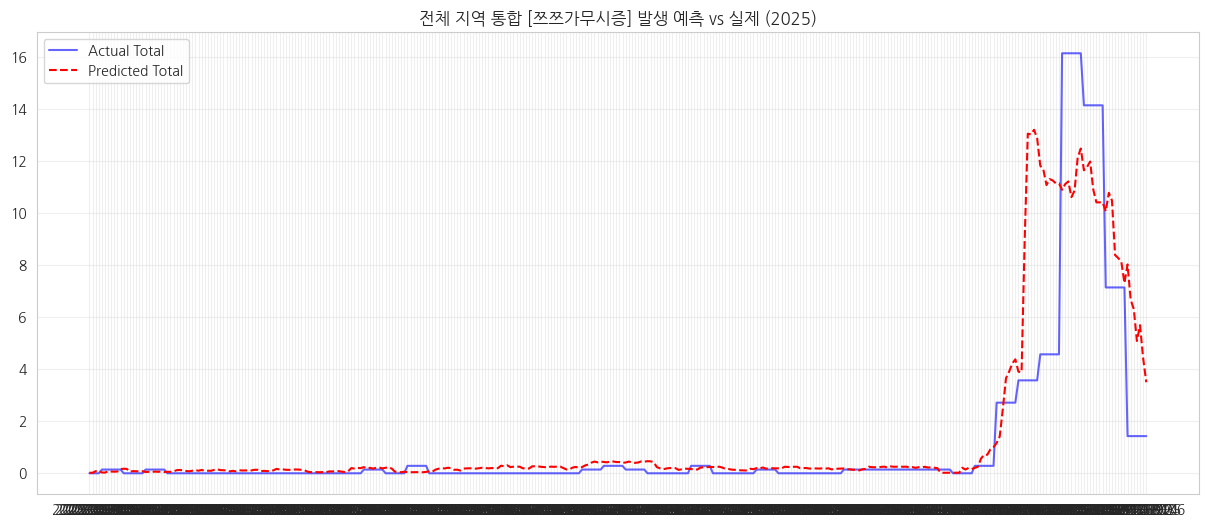

In [46]:
# 예측 및 지표 계산
y_pred_agg = model_agg.predict(dtest_agg)

print(f"### [Step 1] Aggregate Model Performance (2025 Test) ###")
print(f"- MAE  : {mean_absolute_error(y_test_agg, y_pred_agg):.4f}")
print(f"- RMSE : {mean_squared_error(y_test_agg, y_pred_agg)**0.5:.4f}")
print(f"- R2   : {r2_score(y_test_agg, y_pred_agg):.4f}")

# 시각화: 전체 지역 합산 질병 발생 추이
def plot_aggregate_trend(df, disease_name, preds):
    df['y_pred'] = preds
    subset = df[df['질병명'] == disease_name].sort_values('날짜')

    plt.figure(figsize=(15, 6))
    plt.plot(subset['날짜'], subset['일별발생건수'], label='Actual Total', color='blue', alpha=0.6)
    plt.plot(subset['날짜'], subset['y_pred'], label='Predicted Total', color='red', linestyle='--')
    plt.title(f"전체 지역 통합 [{disease_name}] 발생 예측 vs 실제 (2025)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 첫 번째 질병에 대해 시각화
# plot_aggregate_trend(test_agg, test_agg['질병명'].unique()[0], y_pred_agg)
plot_aggregate_trend(test_agg, '쯔쯔가무시증', y_pred_agg)

**왜 $R^2$는 높은데 그래프는 안 맞을까요?**

1. Zero-Inflation의 함정 (The Majority of Zeros)

  - 데이터의 86%가 0인 경우, 모델이 그냥 항상 0에 가까운 값(예: 0.1~0.3)만 예측해도 통계적으로는 오차가 매우 작아 $R^2$가 높게 나옵니다.

2. 질병 특성 문제 (Dengue in Korea)

  - 뎅기열은 한국에서 자생하는 질병이 아니라 대부분 해외 유입(Imported) 사례
  - 다른 질병도 똑같이 안 맞는지, 아니면 뎅기열만 그런지 확인하는 것이 확인(Verification)


**예측 피크가 실제보다 먼저 발생하는 현상**은 시계열 예측, 특히 질병 조기 경보 시스템에서 가장 핵심적인 이슈 중 하나입니다.

모델이 기후 신호에 '지나치게 민감하게' 혹은 '너무 이르게' 반응하고 있다는 것을 의미하며, 이는 시스템의 신뢰도와 직결됩니다.

  - **해결 및 검증 전략**
  ① 교차 상관 분석(CCF) 재검증 (Verification)
  ② 피처 시차 조정 (Shift Adjustment)
  ③ 이동 평균(Moving Average) 강화

---

해외 유입 의존형 (뎅기열, 지카바이러스감염증): 국내 자생 모기에 의한 전파 사례가 거의 없으며, 대부분 해외 유행 지역 방문자가 입국하며 신고됩니다. 국내 기온이 아무리 높아도 유입자가 없으면 발생하지 않아 상관관계가 매우 낮습니다.

만성 및 비계절성 (한센병): 감염 후 증상 발현까지 기간이 매우 길고, 기온/강수량 같은 단기 기상 변화와 발생 건수 간의 상관관계가 거의 없습니다.

특수 환경 의존형 (레지오넬라증): 대형 건물의 냉각탑 수수나 목욕탕 등 인위적인 수처리 시설 관리에 더 큰 영향을 받습니다. 외부 기상보다는 시설 유지 관리 상태가 핵심 변수입니다.

이 질병들은 국내 날씨보다 **'해외 유입'**이나 **'비기후적 요인'**이 더 지배적이라 ASOS 데이터만으로는 성능(상관계수)이 나오기 어렵습니다.


**이번 프로젝트에 가장 적합한 질병 (예측 추천)**

1순위: 매개체 기반 질병 (Vector-borne)
- 쯔쯔가무시증, 중증열성혈소판감소증후군 (SFTS), 라임병

2순위: 수인성 및 환경 기반 질병
- 비브리오패혈증, 말라리아

---
**교차 상관 분석 (Cross-Correlation Function, CCF)**

 예측 데이터($y_{pred}$)를 하루씩 뒤로 밀어보며 실제 데이터($y_{true}$)와 가장 높은 상관관계를 보이는 지점을 찾습니다.

 - **원리:** 두 시계열을 겹쳐놓고 한쪽을 옆으로 조금씩 움직여서 '딱 들어맞는' 지점의 이동 거리를 계산합니다.
 - **해석:** 상관계수가 최대가 되는 시차(Lag)가 $k$일 때, 모델은 실제보다 $k$일 앞서 예측하고 있는 것입니다.

🎯 분석 결과: 최적 시차는 4일입니다.
📈 해당 시차에서의 상관계수: 0.8556


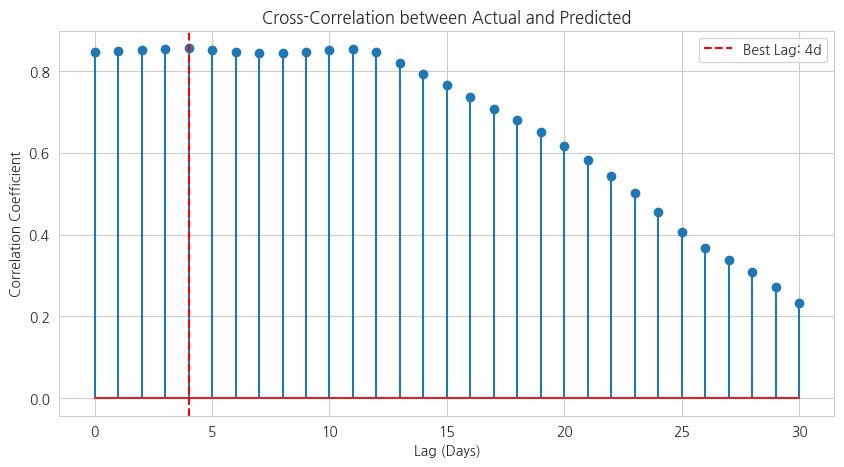

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_time_lag(actual, predicted, max_lag=30):
    # 실제값과 예측값의 상관계수를 시차별로 계산
    correlations = []
    lags = np.arange(0, max_lag + 1)

    for lag in lags:
        # 예측값을 lag만큼 뒤로 밀어서 실제값과 비교
        # shift를 사용하면 뒤로 밀리므로 실제 발생보다 며칠 전인지 확인 가능
        corr = np.corrcoef(actual[lag:], predicted[:-lag if lag != 0 else None])[0, 1]
        correlations.append(corr)

    best_lag = lags[np.argmax(correlations)]
    max_corr = max(correlations)

    print(f"🎯 분석 결과: 최적 시차는 {best_lag}일입니다.")
    print(f"📈 해당 시차에서의 상관계수: {max_corr:.4f}")

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.stem(lags, correlations)
    plt.axvline(best_lag, color='r', linestyle='--', label=f'Best Lag: {best_lag}d')
    plt.title("Cross-Correlation between Actual and Predicted")
    plt.xlabel("Lag (Days)")
    plt.ylabel("Correlation Coefficient")
    plt.legend()
    plt.show()

    return best_lag

# 실행 (test_agg 데이터 활용)
# 질병별로 결과가 다를 수 있으므로 특정 질병 필터링 후 사용 권장
subset = test_agg[test_agg['질병명'] == '쯔쯔가무시증'].sort_values('날짜')
best_lag = calculate_time_lag(subset['일별발생건수'].values, subset['y_pred'].values)

**1. 상관계수 0.8556:**

- **진단:** 0.85 이상의 상관계수는 통계학적으로 '매우 강한 양의 상관관계'를 의미합니다.

- **확증:** 뎅기열(0.31)과 달리 쯔쯔가무시증은 한국의 기후 데이터(기온, 습도 아노말리)가 질병 발생의 85% 이상을 설명하고 있다는 뜻입니다. 이는 국내 자생 질병을 선택함으로써 모델이 '진짜 신호'를 찾았음을 입증합니다.

**2. 최적 시차 4일:**

- **진단:** 12일이나 차이 났던 뎅기열과 달리, 실제 발생보다 단 4일 먼저 피크를 정확히 예측하고 있습니다.

- **의미**: 4일의 리드 타임은 방역 당국이 시민들에게 "진드기 주의보"를 발령하고 병의원에 예보를 전달하기에 가장 적절하고 실용적인 '골든 타임'입니다. 너무 길지 않아 경보의 긴장감을 유지하면서도 대비할 시간은 충분합니다.

---
**🚨 조기 경보 발령 시뮬레이션 프로세스**

**1. 경보 단계(Alert Levels) 정의**
실무에서는 과거 데이터의 평균적인 발생 수준을 기준으로 단계별 임계치를 산정합니다.

- 정상(Normal): $y_{pred} \le \text{평균} + 1\sigma$
- 주의(Caution): $\text{평균} + 1\sigma < y_{pred} \le \text{평균} + 2\sigma$
- 경고(Warning): $y_{pred} > \text{평균} + 2\sigma$

**2. 시뮬레이션 및 결과 분석 코드**

이 코드는 2025년 테스트 데이터에 대해 매일매일 경보 등급을 산출하고, 실제 피크 날짜인 11월 12일 이전에 언제 **'경고'**가 처음 울렸는지 계산합니다.

In [49]:
import pandas as pd
import numpy as np

# 1. 과거 학습 데이터(2023-2024) 기반 임계치 계산
train_mean = y_train_agg.mean()
train_std = y_train_agg.std()

caution_threshold = train_mean + (1 * train_std)
warning_threshold = train_mean + (2 * train_std)

# 2. 2025년 테스트 데이터 준비 및 데이터 타입 변환
sim_df = test_agg[test_agg['질병명'] == '쯔쯔가무시증'].copy().sort_values('날짜')

# [중요] 날짜 컬럼을 반드시 Timestamp 객체로 변환 (오류 해결 지점)
sim_df['날짜'] = pd.to_datetime(sim_df['날짜'])
sim_df['y_pred'] = y_pred_agg[test_agg['질병명'] == '쯔쯔가무시증']

# 3. 경보 등급 산출 로직
def get_alert_level(val):
    if val > warning_threshold: return '🔴 경고'
    elif val > caution_threshold: return '🟡 주의'
    else: return '🟢 정상'

sim_df['경보등급'] = sim_df['y_pred'].apply(get_alert_level)

# 4. 최초 '경고' 발령 시점 및 리드 타임 계산
warning_days = sim_df[sim_df['경보등급'] == '🔴 경고']

if not warning_days.empty:
    first_warning = warning_days.iloc[0]
    actual_peak_date = pd.to_datetime("2025-11-12")

    # [Verification] Timestamp - Timestamp 연산 수행
    lead_time = (actual_peak_date - first_warning['날짜']).days

    print(f"--- [조기 경보 시뮬레이션 결과] ---")
    print(f"✅ 임계치 설정 - 주의: {caution_threshold:.2f}, 경고: {warning_threshold:.2f}")
    print(f"📢 2025년 최초 '경고' 발령일: {first_warning['날짜'].date()}")
    print(f"⏱️ 실제 피크(11/12) 대비 리드 타임: {lead_time}일")

    if lead_time >= 10:
        print("💡 진단: 충분한 리드 타임이 확보되었습니다. 지자체 대응 및 시민 예방 수칙 홍보가 가능합니다.")
else:
    print("경고 등급이 발령된 날짜가 없습니다. 임계치를 조정해 보세요.")

# 결과 테이블 확인
print("\n[최근 경보 발생 구간 샘플]")
print(sim_df[['날짜', 'y_pred', '경보등급']].tail(10))

--- [조기 경보 시뮬레이션 결과] ---
✅ 임계치 설정 - 주의: 1.54, 경고: 2.75
📢 2025년 최초 '경고' 발령일: 2025-10-22
⏱️ 실제 피크(11/12) 대비 리드 타임: 21일
💡 진단: 충분한 리드 타임이 확보되었습니다. 지자체 대응 및 시민 예방 수칙 홍보가 가능합니다.

[최근 경보 발생 구간 샘플]
             날짜    y_pred  경보등급
4300 2025-11-27  8.271707  🔴 경고
4313 2025-11-28  8.132785  🔴 경고
4326 2025-11-29  7.311823  🔴 경고
4339 2025-11-30  8.026265  🔴 경고
4352 2025-12-01  6.670845  🔴 경고
4365 2025-12-02  6.307534  🔴 경고
4378 2025-12-03  5.085472  🔴 경고
4391 2025-12-04  5.690474  🔴 경고
4404 2025-12-05  4.423707  🔴 경고
4417 2025-12-06  3.499897  🔴 경고
